In [1]:
!pip install nltk
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import sklearn
import gensim
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import re
from html.parser import HTMLParser

In [3]:
df = pd.read_csv('./prepared.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    49159 non-null  int64  
 1   label                 31962 non-null  float64
 2   tweet                 49159 non-null  object 
 3   clean_tweet           49157 non-null  object 
 4   tweet_token           49159 non-null  object 
 5   tweet_token_filtered  49159 non-null  object 
 6   tweet_stemmed         49159 non-null  object 
 7   tweet_lemmatized      49159 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.0+ MB


In [5]:
df.head()

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"['when', 'father', 'is', 'dysfunctional', 'and...","['father', 'dysfunctional', 'selfish', 'drags'...","['father', 'dysfunct', 'selfish', 'drag', 'kid...","['father', 'dysfunctional', 'selfish', 'drag',..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"['thanks', 'for', 'lyft', 'credit', 'can', 'no...","['thanks', 'lyft', 'credit', 'use', 'cause', '...","['thank', 'lyft', 'credit', 'use', 'caus', 'of...","['thanks', 'lyft', 'credit', 'use', 'cause', '..."
2,3,0.0,bihday your majesty,bihday your majesty,"['bihday', 'your', 'majesty']","['bihday', 'majesty']","['bihday', 'majesti']","['bihday', 'majesty']"
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in urð,"['model', 'love', 'you', 'take', 'with', 'you'...","['model', 'love', 'take', 'time', 'urð']","['model', 'love', 'take', 'time', 'urð']","['model', 'love', 'take', 'time', 'urð']"
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"['factsguide', 'society', 'now', 'motivation']","['factsguide', 'society', 'motivation']","['factsguid', 'societi', 'motiv']","['factsguide', 'society', 'motivation']"


1. Создайте мешок слов с помощью sklearn.feature_extraction.text.CountVectorizer.fit_transform().  
Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.


- Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
- Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
- Исключим стоп-слова с помощью stop_words='english'.
- Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью CountVectorizer.get_feature_names().


In [6]:
count_bow_vectorizer = sklearn.feature_extraction.text.CountVectorizer(max_df=0.90, max_features=1000, stop_words='english')

In [7]:
bow_stemmed = count_bow_vectorizer.fit_transform(df['tweet_stemmed'])
count_bow_stemmed = pd.DataFrame.sparse.from_spmatrix(columns=count_bow_vectorizer.get_feature_names(), data=bow_stemmed)

In [8]:
bow_lemma = count_bow_vectorizer.fit_transform(df['tweet_lemmatized'])
count_bow_lemma = pd.DataFrame.sparse.from_spmatrix(columns=count_bow_vectorizer.get_feature_names(), data=bow_lemma)

2. Создайте мешок слов с помощью sklearn.feature_extraction.text.TfidfVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.  


- Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
- Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
- Исключим стоп-слова с помощью stop_words='english'.
- Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью TfidfVectorizer.get_feature_names().


In [9]:
tfidf_bow_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.90, max_features=1000, stop_words='english')

In [10]:
bow_stemmed = tfidf_bow_vectorizer.fit_transform(df['tweet_stemmed'])
tfidf_bow_stemmed = pd.DataFrame.sparse.from_spmatrix(columns=tfidf_bow_vectorizer.get_feature_names(), data=bow_stemmed)

In [11]:
bow_lemma = count_bow_vectorizer.fit_transform(df['tweet_lemmatized'])
tfidf_bow_lemma = pd.DataFrame.sparse.from_spmatrix(columns=tfidf_bow_vectorizer.get_feature_names(), data=bow_lemma)

3. Натренируем gensim.models.Word2Vec модель на наших данных.  
Тренировать будем на токенизированных твитах combine_df['tweet_token']  


- Установим следующие параметры: size=200, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 32, seed = 34.
- Используем функцию train() с параметром total_examples равным длине combine_df['tweet_token'], количество epochs установим 20.


In [12]:
from gensim.models import Word2Vec

In [13]:
w2v_vectorizer = Word2Vec(corpus_file='./corpus', size=200, window=5, min_count=2, sg=1, hs=0, negative=10, workers=32, seed=34)

In [14]:
w2v_vectorizer.train(df['tweet_token'], total_examples=df['tweet_token'].shape[0], epochs=20)

(56290942, 104799860)

In [15]:
w2v_vectorizer.save('w2v_vectorizer.model')

4. Давайте немного потестируем нашу модель Word2Vec и посмотрим, как она работает. Мы зададим слово positive = "dinner", и модель вытащит из корпуса наиболее похожие слова c помощью функции most_similar. То же самое попробуем со словом "trump".

In [16]:
w2v_vectorizer.most_similar(positive="dinner")

[('fingernails', 0.98077392578125),
 ('audiobooks', 0.9793781638145447),
 ('travelling.', 0.9793522953987122),
 ('networks', 0.9790804982185364),
 ('cassette,', 0.9786995649337769),
 ('photographic', 0.9783700704574585),
 ('concurrently', 0.978117823600769),
 ('Tuesday.', 0.9781143665313721),
 ('characteristic', 0.9779312610626221),
 ('belts', 0.9779056906700134)]

In [17]:
w2v_vectorizer.most_similar("trump")

KeyError: "word 'trump' not in vocabulary"

In [18]:
from sklearn.manifold import TSNE

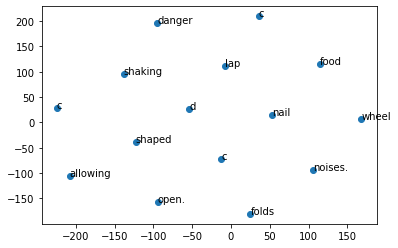

In [19]:
word = 'food'
model = w2v_vectorizer

arr = np.empty((0,200), dtype='f')
word_labels = [word]

close_words = model.similar_by_word(word)
not_close_words = ['dog', 'cucumber', 'car', 'computer']

arr = np.append(arr, np.array([model[word]]), axis=0)
for wrd_score in close_words:
    wrd_vector = model[wrd_score[0]]
    word_labels.append(wrd_score[0])
    arr = np.append(arr, np.array([wrd_vector]), axis=0)
    
for wrd_score in not_close_words:
    wrd_vector = model[wrd_score[0]]
    word_labels.append(wrd_score[0])
    arr = np.append(arr, np.array([wrd_vector]), axis=0)

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
# plt.xlim(x_coords.min()+0.5, x_coords.max()+0.5)
# plt.ylim(y_coords.min()+0.5, y_coords.max()+0.5)
plt.show()

In [ ]:
# так себе рядом